<a href="https://colab.research.google.com/github/madlab-biosig/exercise-12-Anik-Paul-cmd/blob/main/exercise-12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<div class="alert-block alert-info alert"> Hello! If this is your first assignment please read the following instructions:

Read the questions carefully and code what is asked in the respective code block whenever you see a ``` #TODO: YOUR CODE HERE. ```
It is important to do the Coding tasks IN ORDER, as the majority of coding blocks are dependent on the
previous coding blocks in the notebook.
Please also note that there is a **raise NotImplementedError()** for each task or function you have to
implement, so don't forget to remove it before testing your code, otherwise you will always get a "not
implemented" error.

You need to manually upload the data used in this exercise to Colab. Just create a folder 'data' and paste the respective files into this folder. Otherwise, you will get a 'File not found' error. You can find the data in StudOn.

Aside from coding blocks, there are also testing blocks to check whether your implementations
are correct, you can run them but do not change the code inside of them.
The tests are determined via the ASSERT STATEMENTS that you see on the testing blocks, which can help you
out during the coding of the exercises. If you pass all the visible asserts, you will probably get a good
grade on the exercise, just remember that there are also hidden tests, so hardcoding the assert statements
won't help you.

REMEMBER: This Colab notebook DOES NOT HAVE AN AUTOSAVE FUNCTION, so whenever you want to close it, please
remember to save it by clicking on the "file" tab in the upper left corner of the page, followed by
clicking on the "Save a copy to GitHub" button and selecting your corresponding GitHub repository:
"madlab-biosig/exercise-x-YourGitHubUsername"

Before you save the final version of your assignment, please make sure everything runs as expected.
First, **restart the kernel** (in the menubar, select Kernel$\rightarrow$Restart) and then **run all
cells** (in the menubar, select Cell$\rightarrow$Run All).
</div>

### BioSig Exercises WS 23/24
---

# Exercise 12

In [2]:
# Imports and basic setup
### UNCOMMENT THE CORRECT ONE
# If you are using Jupyter Lab
%matplotlib inline

# If you are using Jupyter Notebook
# %matplotlib notebook

import matplotlib.pyplot as plt
plt.rcParams.update({'figure.max_open_warning': 40})
import pandas as pd
import numpy as np
import scipy
import scipy.signal
from pathlib import Path
import seaborn as sns
from sklearn.model_selection import train_test_split

# Comparing PVC and healthy peaks

Last exercise we calculated a wide set of features on a sample ECG recording.
In this exercise, we want to use these features to build a classifier that can separate healthy from PVC (premature ventricular contraction) heart beats.

## Ex 12.1: Data Cleaning
We are going to use the [MIT ECG database](https://physionet.org/content/mitdb/1.0.0/), which was mentioned multiple times in the lecture, for this analysis.
You can find a formatted and structured version of the DB in the `data` folder.
The files have the following structure:

- {patient_id}.csv -> The ECG recording
- {patient_id}_all.csv -> The position of the R-peaks of all heart beats (PVC or normal). All heart beats that show a different condition than PVC are already excluded
- {patient_id}_pvc.csv -> The position of all PVC heart beats in the recording.

Not all patients in the database have PVC heart beats in the recordings.

a) Find all patients that have PVC heart beats **and** normal beats

b) Create a label vector for each patient. This should consist of a 2 column dataframe. The first column should be the position of the R-peak and the second should either be `"PVC"` or `"N"`, indicating a healthy or pathological beat.

c) Count how many PVC vs. normal heart beats exist for these filtered patients

d) Based on your findings, describe potential issues a classification using this data could have.

In [1]:
# A) Work on the pvc_ids function to obtain all the patient ids that contain PVC beats



def pvc_ids():
    """Function that obtains the ids of all patients in the data folder
    that have both PVC and normal heartbeats in their data

    Returns:
        patients_with_pvc: A numpy array with the ids (integers) of all patients
        that have both PVC and normal heartbeats in their data
    """
    data = Path('./data')
    patients_with_pvc = []

    # YOUR CODE HERE
    for pvc_file in data.glob('*_pvc.csv'):
        patient_id = int(pvc_file.stem.split('_')[0])
        normal_file = data / f'{patient_id}_all.csv'

        if normal_file.exists() and pvc_file.exists():

            pvc_df = pd.read_csv(pvc_file)
            normal_df = pd.read_csv(normal_file)

            if pvc_df.shape[0] > 0 and normal_df.shape[0] > 0 and pvc_df.shape != normal_df.shape:
                    patients_with_pvc.append(patient_id)

    return patients_with_pvc


In [3]:
##### DO NOT MODIFY THE LINES OF CODE IN THIS BLOCK
#Run Test your pvc_ids function

#Remember that the output of pvc_ids has to be a numpy array of integers
### BEGIN TESTS
patients_with_pvc= np.sort(pvc_ids())
print(patients_with_pvc)


assert patients_with_pvc.size==30,f"You function is not working properly, you are missing or lacking one or more patients"
assert not (101 in patients_with_pvc),f"You have selected a patient that does not fulfill the criteria. Some patients only have PVC heartbeats and no normal ones"
assert not (220 in patients_with_pvc),f"You have selected a patient that does not fulfill the criteria. Some patients only have PVC heartbeats and no normal ones"
assert patients_with_pvc[3] == 105, f"You function is not working properly, a value in your array seems to be incorrect"
assert patients_with_pvc[7] == 116, f"You function is not working properly, a value in your array seems to be incorrect"
assert patients_with_pvc[24] == 223, f"You function is not working properly, a value in your array seems to be incorrect"

print("\n\n\t\tPreliminary Tests Passed :)\n\n")
### END TESTS


[100 102 104 105 106 108 114 116 119 121 123 200 201 202 203 205 208 209
 210 213 215 217 219 221 223 228 230 231 233 234]


		Preliminary Tests Passed :)




In [4]:
#B) Create label vectors
def create_label_vectors():
    """Function that labels the R peaks of patients. The order should include the id of the patient first,
    followed by the index location of the R peak and finally the label of the peak.

    Returns:
        all_beat_labels: A dataframe with 3 rows with the headers for patient_id , R peaks and heartbeat labels, which contains
        the information of all heartbeats and classifies them either as normal ("N") or PVC ("PVC")

        Example output (YOU HAVE TO COPY THE EXACT FORMAT FOR THE AUTOMATIC GRADING TO WORK):
         patient_id     R      label
0        100            77     N
1        100            370    N
2        100            662    N
3        100            946    N
.
.
.
.
55       100           32675   PVC
    """
    # YOUR CODE HERE
    data = Path('./data')
    all_beat_labels_data = []

    for normal_file in data.glob('*_all.csv'):
        patient_id = int(normal_file.stem.split('_')[0])
        pvc_file = data / f'{patient_id}_pvc.csv'

        if pvc_file.exists() and normal_file.exists():
            pvc_df = pd.read_csv(pvc_file)

            normal_df = pd.read_csv(normal_file)
            if pvc_df.shape[0] > 0 and normal_df.shape[0] > 0 and pvc_df.shape != normal_df.shape:

                patient_labels_data = pd.DataFrame({
                    'patient_id': [patient_id] * len(normal_df),
                    'R': normal_df['R'].values,
                    'label': 'N'
                })
                pvc_indices = pvc_df['PVC'].values
                patient_labels_data.loc[patient_labels_data['R'].isin(pvc_indices), 'label'] = 'PVC'
                all_beat_labels_data.append(patient_labels_data)

    all_beat_labels = pd.concat(all_beat_labels_data, ignore_index=True)
    all_beat_labels = all_beat_labels.sort_values(by=['patient_id', 'R'])
    all_beat_labels.reset_index(drop=True, inplace=True)
    return all_beat_labels




In [5]:
##### DO NOT MODIFY THE LINES OF CODE IN THIS BLOCK
#Test your create_label_vectors function

#REMEMBER TO USE THE FORMAT GIVEN IN EXAMPLE OUTPUT (even the header names)

### BEGIN TESTS
all_beat_labels = create_label_vectors()

print(all_beat_labels.head(5))
print(all_beat_labels.size)

assert all_beat_labels.size==187470, f"There is something wrong in your function, the size of the dataframe does not match the solution"
assert all_beat_labels.loc[4]["R"]== 1231,f"There is something wrong in your function, there is a value mismatch with the correct answer"
assert all_beat_labels.loc[499]["R"]== 145111,f"There is something wrong in your function, there is a value mismatch with the correct answer"
assert all_beat_labels.loc[4999]["patient_id"]== 105,f"There is something wrong in your function, there is a value mismatch with the correct answer"
assert all_beat_labels.loc[62488]["patient_id"]== 234,f"There is something wrong in your function, there is a value mismatch with the correct answer"
assert all_beat_labels.loc[3195]["label"]== "N",f"There is something wrong in your function, there is a value mismatch with the correct answer"
assert all_beat_labels.loc[31915]["label"]== "N",f"There is something wrong in your function, there is a value mismatch with the correct answer"
assert all_beat_labels.loc[2339]["label"]== "PVC",f"There is something wrong in your function, there is a value mismatch with the correct answer"


print("\n\n\t\tPreliminary Tests Passed :)\n\n")
### END TESTS



   patient_id     R label
0         100    77     N
1         100   370     N
2         100   662     N
3         100   946     N
4         100  1231     N
187470


		Preliminary Tests Passed :)




In [6]:
#C)  Count PVC vs non PVC heartbeats
def count_heartbeats(all_beat_labels):
    """Function that obtains the count number of normal and PVC heartbeats for all patients

    Arguments: all_beat_labels: A dataframe with the same format as the previous task b)

    Returns:
        N: The total number of normal Heartbeats within the dataframe
        PVC: The total number of PVC Heartbeats within the dataframe
    """
    # YOUR CODE HERE
    N = all_beat_labels[all_beat_labels['label'] == 'N'].shape[0]
    PVC = all_beat_labels[all_beat_labels['label'] == 'PVC'].shape[0]
    return N, PVC



In [7]:
##### DO NOT MODIFY THE LINES OF CODE IN THIS BLOCK
##Run this cell to check your count_heartbeats function implementation
#Remeber that there are hidden tests, so don't just create a function that delivers the values in the assert ;)

### BEGIN TESTS
N, PVC =  count_heartbeats(all_beat_labels)
print("Normal Heartbeats: ",N,"\nPVC Heartbeats: ",PVC)

assert N == 55882,f"Your function is not counting the heartbeats properly"
assert PVC== 6608,f"Your function is not counting the heartbeats properly"


print("\n\n\t\tPreliminary Tests Passed :)\n\n")
### END TESTS


Normal Heartbeats:  55882 
PVC Heartbeats:  6608


		Preliminary Tests Passed :)




## Ex. 12.2: Calculating features

As we learned in the lecture, we need to reduce the dimensionality of our data by calculating features for each heartbeat.

a) Using the code from last exercise, extract all heartbeats from the selected patients.

b) Calculate all features from last exercise for all heart beats. Use the first **healthy** heart beat of each patient for the template feature.

c) Calculate a set of “generic” features for each heart beat: *mean*, *std*, *minimum*, *maximum*

d) Compose all features into one matrix, where each row belongs to one heartbeat. Create a single matrix/`pd.DataFrame` combining all patients.
Also like in the last exercise, before calculating the features utilize a 3-50 Hz fifth order Butterworth Bandpass filter on the ECG signal of each patient

In [8]:
# Helper funcs from last exercise
def extract_qrst_complexes(signal, r_peaks, sampling_rate=360):
    """Extract all qrst complexes from a continous signal.

    Cuts out a region of -50ms to 300ms around each provided R-peak

    Args:
        signal: np.array of ecg signal
        r_peaks: list of indices indicating the postion of R-peaks in the signal
        sampling_rate: Ssampling rate of the recording

    Returns:
        qrst: np.array with fixed number of culumns and one qrst complex per row
    """
    signal = np.array(signal)
    start = r_peaks - int(50 / 1000 * sampling_rate)
    end = r_peaks + int(300 / 1000 * sampling_rate)

    qrst = []
    for s, e in zip(start, end):
        qrst.append(signal[s:e])
    qrst = np.array(qrst)
    return qrst

def find_q_peak(qrst, sampling_rate=360):
    """Find the Q peak in an array of qrst complexes extracted before.

    The Q peak is the first valley to the left of the R-Peak

    Returns:
        The relative distance from the R-Peak in samples
    """
    r_peak_pos = int(50/1000 * sampling_rate)
    index_q = np.argmin(qrst[:, :r_peak_pos], axis=-1)
    index_q = r_peak_pos - index_q
    return index_q

def find_s_peak(qrst, sampling_rate=360):
    """Find the S peak in an array of qrst complexes extracted before.

    The S peak is the first valley to the right of the R-Peak

    Returns:
        The relative distance from the R-Peak in samples
    """
    r_peak_pos = int(50/1000 * sampling_rate)
    # Search 80ms to the right of the r_peak
    search_index = int(80/1000 * sampling_rate)

    index_s = np.argmin(qrst[:, r_peak_pos: r_peak_pos + search_index], axis=-1)
    index_s = index_s
    return index_s

In [9]:
# Functions for task b)

def qrs_width_calc(peaks,sampling_rate=360):
    """Extract the QRS width for a given ECG signal and its peaks

    Args:
        signal: np.array of ecg signal
        peaks: pd.DataFrame with columns called "R","Q" and "S" containing the position of all R-, Q- and S-peaks respectively
        sampling_rate: Sampling rate of the recording

    Returns:
        QRS_Width: Array with the information of all the QRS widths (in seconds)
    """

    # YOUR CODE HERE
    QRS_Width = (peaks['S'] - peaks['Q']) / sampling_rate


    return QRS_Width

def qr_amplitude_calc(signal,peaks):
    """Extract the QR Amplitude for a given ECG signal and its peaks

    Args:
        signal: np.array of ecg signal
        peaks: pd.DataFrame with columns called "R","Q" and "S" containing the position of all R-, Q- and S-peaks respectively
        sampling_rate: Sampling rate of the recording

    Returns:
        QR_Amplitude: Float Array with the information of all the QR Amplitudes
    """
    # Calculate the amplitude difference between the R-peak and the Q-valey
    # YOUR CODE HERE
    QR_Amplitude = signal.values[peaks['R'].values] - signal.values[peaks['Q'].values]


    return QR_Amplitude

def rs_amplitude_calc(signal,peaks):
    """Extract the RS Amplitude for a given ECG signal and its peaks

    Args:
        signal: np.array of ecg signal
        peaks: pd.DataFrame with columns called "R","Q" and "S" containing the position of all R-, Q- and S-peaks respectively
        sampling_rate: Sampling rate of the recording

    Returns:
        QR_Amplitude: Float Array with the information of all the RS Amplitudes
    """
    # Calculate the amplitude difference between the R-peak and the S-valey
    # YOUR CODE HERE
    RS_Amplitude = signal.values[peaks['R'].values] - signal.values[peaks['S'].values]


    return RS_Amplitude


def qrst_area_calc(qrst_complexes):
    """Extract the QRST area for a given ECG signal and its peaks

    Args:
        qrst_complexes: np.array with fixed number of columns and one qrst complex per row

    Returns:
        QRST_Area: Float Array with the information of all the QRST areas
    """
    # Calculate the area under each QRST complex after substracting the mean value of each complex to normalize the baseline
    # YOUR CODE HERE
    QRST_Area = np.sum(np.abs((qrst_complexes.T - np.mean(qrst_complexes,axis=-1)).T), axis=-1)


    return QRST_Area

def template_calc(qrst_complexes,labels):
    """Extract the first QRS template for a given qrst complexes array

    Args:
        qrst_complexes: np.array with fixed number of columns and one qrst complex per row

    Returns:
        Template: First healthy QRS complex
    """
    # Find the first "normal QRS" complex
    # Assume the first peak in the series is a normal QRST complex
    # Substract the baseline (minimum) from every qrst complex and then calculate the normalised dot-product

    # YOUR CODE HERE
    baseline_corrected_qrst = (qrst_complexes.T - np.min(qrst_complexes, axis=-1)).T
    baseline_corrected_norm = np.linalg.norm(baseline_corrected_qrst, axis=-1)
    distance = np.dot(baseline_corrected_qrst, baseline_corrected_qrst[0])
    distance /= baseline_corrected_norm * baseline_corrected_norm[0]
    Template = distance
    return Template

# Function for task c)
def generic_features_calc(qrst_complexes):
    """Extract the generic information of the QRSt complexes to use as features

    Args:
        qrst_complexes: np.array with fixed number of columns and one qrst complex per row

    Returns:
        Mean: The mean value of the QRST complexes
        Std:  The standard deviation value of the QRST complexes
        Min:  The minimum value of the QRST complexes
        Max:  The maximum value of the QRST complexes
    """

    # YOUR CODE HERE
    Mean = np.mean(qrst_complexes, axis=1)
    Std = np.std(qrst_complexes, axis=1)
    Min = np.min(qrst_complexes, axis=1)
    Max = np.max(qrst_complexes, axis=1)
    return Mean, Std, Min, Max


def calc_all_features_for_patient(signal, peaks, labels):
    """Extract all heartbeats and calc all features for a patient.

    Args:
        signal: np.array of ecg signal
        peaks: pd.DataFrame with a column called "R" containing the position of all R-peaks
        labels: array with either "N" or "PVC" for each r-peak

    Returns:
        DataFrame with 1 column per feature and 1 column for the label
    """
    peaks = peaks.copy()
    # Remove peaks that are too close to the beginning or end of the dataset
    peaks = peaks[peaks['R'].between(20, len(signal) - 110)]

    # Extract the individual complexeses and important events withing the complex
    qrst_complexes = extract_qrst_complexes(signal, peaks['R'], sampling_rate=360)
    peaks['Q'] = peaks['R'] - find_q_peak(qrst_complexes)
    peaks['S'] = peaks['R'] + find_s_peak(qrst_complexes)

    features = pd.DataFrame()

    # Calculate all features from last week

    # QRS Width
    features['QRS_Width'] = qrs_width_calc(peaks,sampling_rate=360)

    # QR Amplitude difference
    features['QR_amplitude'] = qr_amplitude_calc(signal,peaks)

    # RS Amplitude difference
    features['RS_amplitude'] = rs_amplitude_calc(signal,peaks)

    # QRST Area
    features['QRST_area'] = qrst_area_calc(qrst_complexes)

    # Template Match
    features['Template'] = template_calc(qrst_complexes,labels)

    # Calculate a set of generic features
    features['Mean'],features['Std'],features['Min'], features['Max'] = generic_features_calc(qrst_complexes)

    # Add the label column
    features['label'] = labels

    return features


In [10]:
##### DO NOT MODIFY THE LINES OF CODE IN THIS BLOCK
## Run this block to test all of your function implementations within calc_all_features_for_patient

print("\n\n\t\tBeginning tests\n\n")

######################preliminary preparations#################################
sampling_rate=360
#Read patient file


for patient in patients_with_pvc:
    Test_signal = pd.read_csv('./data/{}.csv'.format(patient), index_col=0)['ecg']

    Test_beats = all_beat_labels[all_beat_labels['patient_id'] == patient]
    break

#Get labels and peaks in the same format as the calc_all_features_for_patient function
Test_labels = Test_beats['label']
Test_peaks = Test_beats[['R']].copy()
Test_peaks = Test_peaks[Test_peaks['R'].between(20, len(Test_signal) - 110)]


# Extract the individual complexeses and important events withing the complex
Test_complexes = extract_qrst_complexes(Test_signal, Test_peaks['R'])

Test_peaks['Q'] = Test_peaks['R'] - find_q_peak(Test_complexes)
Test_peaks['S'] = Test_peaks['R'] + find_s_peak(Test_complexes)

#################### Begin non-hidden asserts###################################

#Test QRS width
QRS_Width = qrs_width_calc(Test_peaks,sampling_rate=360)

assert np.max(QRS_Width)<1,f"Your QRS Width calculator output does not match the size of the result, you probably forgot to give the output in seconds instead of samples"
assert QRS_Width.size == 2239,f"Your QRS Width calculator output does not match the size of the result"
assert np.around(np.mean(QRS_Width),4)==0.0457,f"Your QRS Width calculator output does not match the correct result"


#Test QR amplitude
QR_Amplitude = qr_amplitude_calc(Test_signal,Test_peaks)

assert QR_Amplitude.size == 2239,f"Your QR Amplitude calculator output does not match the size of the result"
assert np.around(np.mean(QR_Amplitude),4)==1.5213,f"Your QR Amplitude calculator output does not match the correct result"

#Test RS amplitude
RS_Amplitude = rs_amplitude_calc(Test_signal,Test_peaks)

assert RS_Amplitude.size == 2239,f"Your RS Amplitude calculator output does not match the size of the result"
assert np.around(np.mean(RS_Amplitude),4)==1.4566,f"Your RS Amplitude calculator output does not match the correct result"

#Test QRST AREA
QRST_Area = qrst_area_calc(Test_complexes)

assert QRST_Area.size == 2239,f"Your QR Amplitude calculator output does not match the size of the result"
assert np.around(np.mean(QRST_Area),4)==17.24,f"Your QRST Area calculator output does not match the correct result"

#Test Template
Template = template_calc(Test_complexes,Test_labels)

assert Template.size == 2239,f"Your QR Amplitude calculator output does not match the size of the result"
assert np.trunc(Template[0]) ==1,f"Your Template calculator output is incorrect, the first heartbeat is the template and thus should perfectly match the template (have a value of 1)"
RestTest = Template[1:]
assert np.max(RestTest)<1,f"Your Template calculator output is incorrect, no heartbeat after the first one should match the template perfectly (they should have a value lower than 1)"
assert np.trunc(Template[0]) ==1,f"Your Template calculator output is incorrect, the first heartbeat is the template and thus should perfectly match the template (have a value of 1)"
assert np.around(np.mean(Template),4)==0.9836,f"Your QRST Area calculator output does not match the correct result"

#Test Generic features
Mean1, Std1, Min1, Max1 = generic_features_calc(Test_complexes)

assert (Mean1.size and Std1.size and Min1.size and Max1.size) == 2239,f"Your Generic features do not match the size of the result"
assert np.around(np.mean(Mean1),4)==-0.3239,f"Your calculated Mean does not match the correct result"
assert np.around(np.mean(Std1),4)==0.2718,f"Your calculated standard deviation does not match the correct result"
assert np.around(np.mean(Min1),4)==-0.5604,f"Your calculated Minimum does not match the correct result"
assert np.around(np.mean(Max1),4)==0.986,f"Your calculated Maximum does not match the correct result"

print("\n\n\t\tAll Preliminary Tests Passed :)\n\n")




		Beginning tests




		All Preliminary Tests Passed :)




In [11]:
#Task d)

sampling_rate = 360  # hz


def All_Patients_Features():
    """
    Use the previously programmed function calc_all_features_for_patient to obtain the features of all the heartbeats for all patients
    Remember to also apply a 5th order Butterworth 3-50 Hz bandpass filter to each signal obtaining the peaks and features.


    Returns:
    pd.DataFrame with the heartbeat features of all patients with the columns given by the calc_all_features_for_patient output

    Example Output for the first 2 elements:

        QRS_Width 	QR_amplitude 	RS_amplitude 	QRST_area 	Template 	Mean    	Std     	Min     	Max     	label
    0 	0.047222 	1.304419    	1.272772    	12.740725 	1.000000 	0.007252 	0.211623 	-0.254819 	1.049600 	N
    1 	0.052778 	1.473421    	1.399725    	16.753887 	0.991165 	0.009106 	0.254250 	-0.311316 	1.162106 	N

    DUE TO GRADING PURPOSES, THE OUTPUT NEEDS TO PERFECTLY MATCH THIS FORMAT
    """
    feature_all_patients = []
    # YOUR CODE HERE
    row = 0
    for patient in patients_with_pvc:
        signal_data = pd.read_csv('./data/{}.csv'.format(patient), index_col=0)['ecg']

        bandpass_filter = scipy.signal.butter(5, (3, 50), btype='bandpass', fs=sampling_rate)
        b, a = bandpass_filter
        signal = pd.Series(scipy.signal.filtfilt(b, a, signal_data))

        peaks = all_beat_labels[all_beat_labels['patient_id'] == patient]
        labels = peaks['label']
        peaks = peaks[['R']].copy()
        features = calc_all_features_for_patient(signal, peaks, labels)

        if row == 0:
            feature_all_patients = features
        else:
            feature_all_patients = pd.concat([feature_all_patients, features])

        row += 1

    return feature_all_patients


In [12]:
##### DO NOT MODIFY THE LINES OF CODE IN THIS BLOCK
##Use this block to test your All patients Features function
### BEGIN TESTS

feature_all_patients = All_Patients_Features()
print(feature_all_patients.head(651))

print(np.around(feature_all_patients.loc[998]["QRST_area"],4))

assert feature_all_patients.size==624830,f"Your all_patients_features function is not working properly, the output size does not match the correct results"
assert np.around(feature_all_patients.loc[494]["QRS_Width"],4) ==0.0472 ,f"Your all_patients_features function output does not match the correct result, check the format or the way you calculated"
assert np.around(feature_all_patients.loc[5925]["QR_amplitude"],4) ==1.344 ,f"Your all_patients_features function output does not match the correct result, check the format or the way you calculated"
assert np.around(feature_all_patients.loc[19]["RS_amplitude"],4) ==1.3971 ,f"Your all_patients_features function output does not match the correct result, check the format or the way you calculated"
assert np.around(feature_all_patients.loc[998]["QRST_area"],4) ==16.9264 ,f"Your all_patients_features function output does not match the correct result, check the format or the way you calculated"
assert np.around(feature_all_patients.loc[339]["Template"],4) ==0.997 ,f"Your all_patients_features function output does not match the correct result, check the format or the way you calculated"
assert np.around(feature_all_patients.loc[7736]["Mean"],4) ==0.0371 ,f"Your all_patients_features function output does not match the correct result, check the format or the way you calculated"
assert np.around(feature_all_patients.loc[646]["Std"],4) ==0.2418 ,f"Your all_patients_features function output does not match the correct result, check the format or the way you calculated"
assert np.around(feature_all_patients.loc[646]["Min"],4) ==-0.3075 ,f"Your all_patients_features function output does not match the correct result, check the format or the way you calculated"
assert np.around(feature_all_patients.loc[646]["Max"],4) ==1.1572 ,f"Your all_patients_features function output does not match the correct result, check the format or the way you calculated"
assert feature_all_patients.loc[646]["label"] =="N" ,f"Your all_patients_features function output does not match the correct result, check the format or the way you calculated"



     QRS_Width  QR_amplitude  RS_amplitude  QRST_area  Template      Mean  \
0     0.047222      1.304419      1.272772  12.740725  1.000000  0.007252   
1     0.052778      1.473421      1.399725  16.753887  0.991165  0.009106   
2     0.044444      1.461040      1.428218  13.951622  0.984203  0.005351   
3     0.047222      1.442177      1.351256  13.375388  0.983333  0.004366   
4     0.044444      1.344296      1.313935  12.736080  0.996275  0.004360   
..         ...           ...           ...        ...       ...       ...   
646   0.047222      1.464690      1.439364  14.668938  0.995366  0.006834   
647   0.050000      1.423707      1.384852  14.642880  0.985449  0.005275   
648   0.047222      1.461870      1.478098  14.909203  0.982131  0.005856   
649   0.044444      1.417234      1.393797  12.712147  0.996056  0.003754   
650   0.044444      1.421172      1.413501  13.484440  0.997428  0.003759   

          Std       Min       Max label  
0    0.211623 -0.254819  1.049600

## Ex. 12.3: Feature Selection

Now that we calculated a set of features it is important to check if they provide the separation we hoped.
This is an important step, as our classifier can never be better than its data/features.
If the features cannot separate our classes of interest, our classifier cannot magically achieve this.

A typical way to do this, is to plot the histogram for each feature.

a) Look at the visualisation below. Discuss what you would expect from a “good” feature.

b) Pick the best 4 features you would consider as the best

c) Explain the limitations of selecting features just based on a 1D histogram

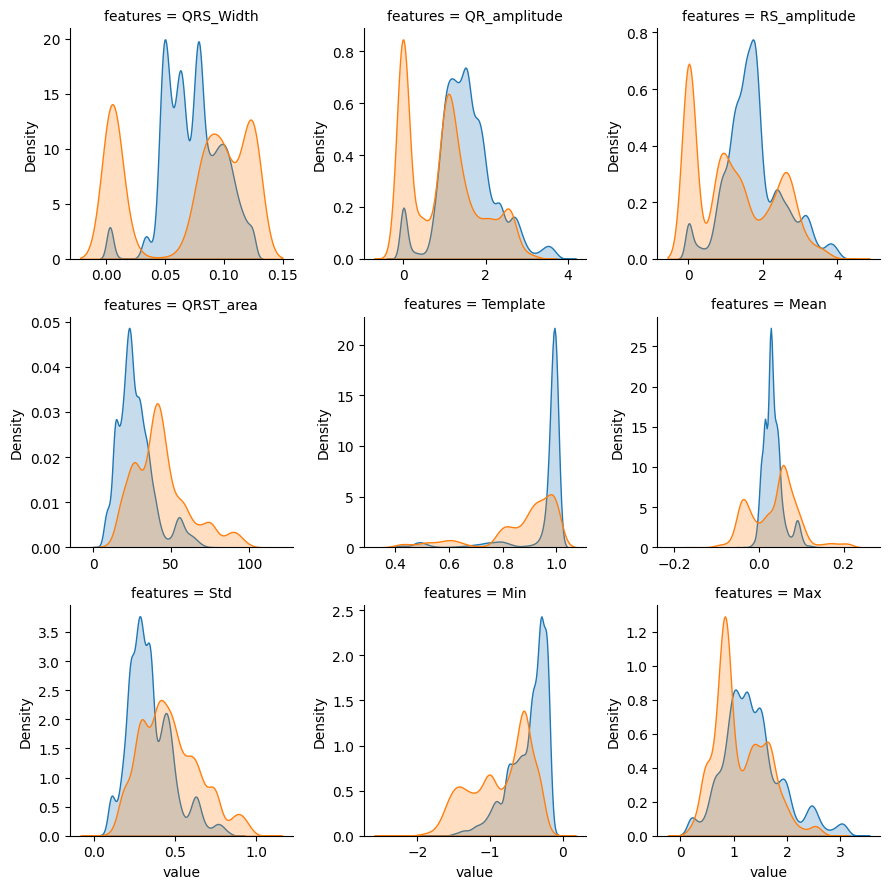

In [13]:
## Run this block too visualize the different feature histograms


plot_longform_df = feature_all_patients.melt(['label'], value_name='value', var_name='features')
g = sns.FacetGrid(plot_longform_df, col='features', hue="label", sharex=False, sharey=False, col_wrap=3)
g = (g.map(sns.kdeplot, 'value', fill=True))

## Ex. 12.4: Training a classifier

With our set of features, we will now train a classifier.
This is usually a crucial step, as the choice of classifier and and its parameters will heavily influence the final performance.
While there are some rules of thumb, most of time this requires some trial and error or a proper grid search.

For this exercise we are going to use a *RandomForestClassifier* (and leave all parameters at default), because it is simple to use and requires no further pre-processing of our features.
Have a look at the [sklearn documentation](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) for further information.

To test the performance of a classifier, we need to decide on a “Test Set”.
A part of our data, we will not use to train the classifier, but only to evaluate its final performance.
This is called a train-test-split and sklearn has some [helper functions](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.train_test_split.html) for this.


a) Use the documentation provided above to assemble a simple pipeline consisting of a train-test-split with 30% test data and stratification.

b) Explain why “stratification” could be important for the given problem and name potential other issues of using a single train-test split like shown here.

c) Train a Random Forest classifier using this train data and calculate the confusion matrix and the accuracy for this classification. Explain the meaning of each entry in the confusion matrix.

d) See how the classification changes with all features (instead of just your selected features). Compare the results.


**FYI: You have to use the random state number given in the code for the split and classifier, otherwise you won't be able to pass the test**

In [14]:
#Preliminary preparations before creating the classifier

#For the next task we will work with the following 4 selected Features:

selected_features = ['QRS_Width', 'Template', 'Min', 'Mean']

#For reproducible results we will utilize the following random state:
Random_state = 44 #Be sure to use it for both the split and the classifier sections


# Features and label vector creation

data = feature_all_patients[selected_features]
labels = feature_all_patients['label']




In [15]:
#a) Train and test data split
from sklearn.model_selection import train_test_split ##Import required in this block for autograding purposes DO NOT REMOVE
def data_split(data,labels):
    """Splits data into training and test data

    Args:
        data: pd.Dataframe containing the ECG selected features
        labels: np.Array that contains the labels "N" or "PVC" for each of the heartbeats in the data

    Returns:
        X_train, X_test, y_train, y_test: Data splits that follow the sklearn format
    """
    # Remember: Use 44 for the random state parameter and  a 30% division for the data stratification
    # YOUR CODE HERE
    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, stratify=labels, random_state=Random_state)

    return X_train, X_test, y_train, y_test

In [16]:
##### DO NOT MODIFY THE LINES OF CODE IN THIS BLOCK
### BEGIN TESTS
#Run this block to test your data_split implementation

X_train, X_test, y_train, y_test = data_split(data,labels)


assert X_train.size ==174952,f"Your data split is not working properly"
assert X_test.size ==74980,f"Your data split is not working properly"
assert y_train.size ==43738,f"Your data split is not working properly"
assert y_test.size ==18745,f"Your data split is not working properly"
### END TESTS


In [17]:
#c) Random Forest classifier

#Create a random forest classifier and fit it with the train data
#Use it to classify the test data and obtain its corresponding confusion matrix and accuracy score

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay


def random_forest(X_train, X_test, y_train, y_test):
    """Creates a random forest classifier with sklearn and also returns its predicted accuracy and confusion matrix on the given data

    Args:
        X_train, X_test, y_train, y_test: Data splits that follow the sklearn format

    Returns:
        classifier: The random forest classifier object created by sklearn
        cf_matrix: The confusion matrix obtained by your classifier when predicting on the test data
        Accuracy: The accuracy obtained by your classifier when predicting on the test data
    """
    # Remember: Use 44 for the random state parameter and leave the other parameters in their standard values
    # YOUR CODE HERE
    classifier = RandomForestClassifier(random_state=Random_state)
    classifier.fit(X_train, y_train)
    y_pred = classifier.predict(X_test)
    cf_matrix = confusion_matrix(y_test, y_pred)
    accuracy = accuracy_score(y_test, y_pred)
    return classifier,cf_matrix,accuracy


Classifier's accuracy:  0.9867164577220592


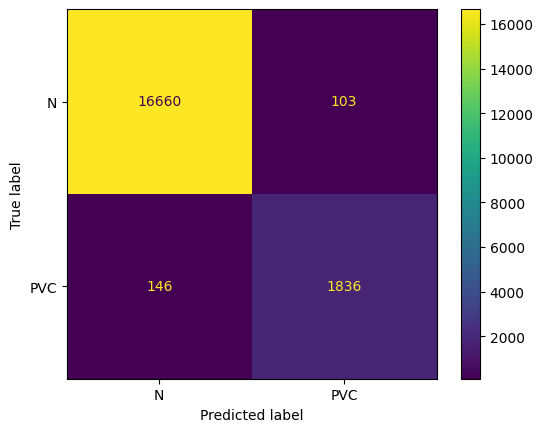

AssertionError: Your random forest implementation is not working properly (check your random state, selected features and data split)

In [18]:
##### DO NOT MODIFY THE LINES OF CODE IN THIS BLOCK
### RUN THIS BLOCK TO TEST YOUR random_forest implementation

### BEGIN TESTS
classifier,cf_matrix, accuracy = random_forest(X_train, X_test, y_train, y_test)
print("Classifier's accuracy: ", accuracy)

disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,display_labels=['N', 'PVC'])
disp.plot()
plt.show()
#plot_confusion_matrix(classifier, X_test, y_test, normalize='true');

assert np.around(accuracy,4)==0.9898,f"Your random forest implementation is not working properly (check your random state, selected features and data split)"
assert cf_matrix[0,0] == 16691,f"Your random forest implementation is not working properly (check your random state, selected features and data split)"
print("\n\n\t\tPreliminary Test Passed :)\n\n")
### END TESTS


0.99365164043745
[[16725    38]
 [   81  1901]]


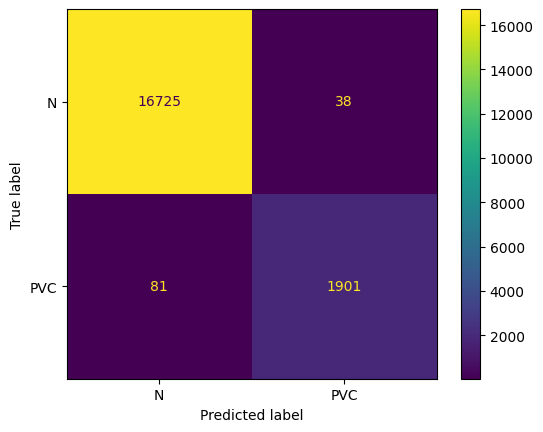

In [19]:
#d) All features classifier
# After passing the previous test block, run this to see how the classification changes with all features


data2 = feature_all_patients.drop(['label'], axis=1)
labels2 = feature_all_patients['label']
X_train2, X_test2, y_train2, y_test2 = data_split(data2,labels2)

classifier,cf_matrix, accuracy = random_forest(X_train2, X_test2, y_train2, y_test2)
print(accuracy)
print(cf_matrix)
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,display_labels=['N', 'PVC'])
disp.plot()
plt.show()


## Ex. 12.5: Discussing classifier performance

a) Would you trust the classifier to make an automatic decision in a clinical environment?

b) For which performance parameter would you try to optimize the classifier performance? (TP-rate or TN-rate?)

c) What other issues do you see with the current system?

In [ ]:
Answer a. Trusting a clinical classifier relies on assessing critical factors like sensitivity, specificity, and overall accuracy,
with enhanced trust stemming from high performance validated on diverse datasets.
It is essential to consider the clinical context and ramifications of false results for informed decision-making.

In [ ]:
Answer b.
Choosing between optimizing for True Positive Rate (sensitivity) or True Negative Rate (specificity) depends on the specific clinical context and goals.
In diagnoses scenarios, we often  overlooking a positive case , which can have severe consequences.
On the other hand, in situations minimizing false positives is critical, it should our the primary focus.

In [ ]:
Answer c.
There are few challenges related to class imbalance, where an unequal distribution of positive and negative cases could affect the classifier.
Tackling numbers of positive and negative cases is a challenge, as it can impact how well the classifier works.
To fix this, it's important to use fair evaluation methods and pay attention to precision and recall.
Also, selecting the right features, making sure the classifier is strong and works well with different inputs, and considering ethical aspects are all crucial when using a classifier in a healthcare setting.